In [21]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('default') # 使用默认样式
from tools_2D import *
from shape_fns import *
from Elements import *
from Mesh import create_mesh, Boundary
import pickle
from scipy.interpolate import griddata

with open("Data/data.pkl", "rb") as f:
    data_ori = pickle.load(f)


In [28]:
def draw(elements_list, dir ='xy',type = 'disp'):
    refine = 3
    global_min = min([np.min([test_element(xy[0], xy[1], dir, type) for xy in test_element.sample_points(refine)]) for test_element in elements_list])
    global_max = max([np.max([test_element(xy[0], xy[1], dir, type) for xy in test_element.sample_points(refine)]) for test_element in elements_list])
    for test_element in elements_list:
        test_mapping = test_element.mapping(refine)
        test_inputs = test_element.sample_points(refine)
        test_output = [test_element(xy[0], xy[1],dir, type) for xy in test_inputs]
        test_x, test_y, test_z = grid_to_mat(test_mapping, test_output)
        plt.imshow(test_z, extent=(test_mapping[:, 0].min(),
                                    test_mapping[:, 0].max(),
                                    test_mapping[:, 1].min(),
                                    test_mapping[:, 1].max()),
                                    origin='lower', aspect='auto',
                                    interpolation='bilinear',
                                        vmin=global_min, vmax=global_max)
            # 绘制元素的边界
        vertices = test_element.vertices
        vertices = np.vstack([vertices, vertices[0]])  # 将第一个顶点再次添加到数组的末尾，以便封闭形状
        vertices_x, vertices_y = zip(*vertices)  # 解压顶点坐标
        plt.plot(vertices_x, vertices_y,  color='white')  # 使用黑色线绘制边界，并使用小圆点表示顶点

    plt.xlim(0, 40)
    plt.ylim(0, 40)
    # Display the color bar
    plt.colorbar()
    plt.legend()
    if type == 'disp':
        type_str = 'U'
    elif type == 'strain':
        type_str = '\\epsilon'
    elif type == 'stress':
        type_str = '\\sigma'
    dir_str = "{ %s }" % dir
    # if dir == 'xy':
    #    dir_str = '{xy}'
    # elif dir == 'von':
    #    dir_str = '{von}'
    # else:
    #    dir_str = dir
    plt.title(rf"${type_str}_{dir_str}$")
    plt.show()

def draw_exact(elements_list, a_b, dir ='x'):
    global_min = min([np.min([exact_fn(xy[0], xy[1],a_b, dir) for xy in test_element.mapping(refine)]) for test_element in elements_list])
    global_max = max([np.max([exact_fn(xy[0], xy[1],a_b, dir)for xy in test_element.mapping(refine)]) for test_element in elements_list])
    for i in range(len(elements_list)):
        test_element = elements_list[i]
        test_mapping = test_element.mapping(refine)
        test_output = [exact_fn(xy[0], xy[1],data_ori[iii]['a_b'], dir) for xy in test_mapping]
        test_x, test_y, test_z = grid_to_mat(test_mapping, test_output)
        plt.imshow(test_z, extent=(test_mapping[:, 0].min(),
                                            test_mapping[:, 0].max(),
                                            test_mapping[:, 1].min(),
                                            test_mapping[:, 1].max()),
                                            origin='lower', aspect='auto',
                                            interpolation='bilinear',
                                                vmin=global_min, vmax=global_max)
                    # 绘制元素的边界
        vertices = test_element.vertices
        vertices = np.vstack([vertices, vertices[0]])  # 将第一个顶点再次添加到数组的末尾，以便封闭形状
        vertices_x, vertices_y = zip(*vertices)  # 解压顶点坐标
        plt.plot(vertices_x, vertices_y,  color='white')  # 使用黑色线绘制边界，并使用小圆点表示顶点s
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    # Display the color bar
    plt.colorbar()
    dir_str = "{ %s }" % dir
    plt.title(rf"Exact solution: $\sigma_{dir_str}$")
    plt.show()

In [23]:
def exact_fn(x, y,a_b, dir='von'):
    b = 20
    a = b*a_b
    sigma_0 = 50 #Mpa
    lambda_ = 1/2*(x**2+y**2-a**2-b**2+((x**2+y**2-a**2+b**2)**2+4*(a**2-b**2) * y**2)**0.5)

            # Define rho_a and rho_b
    rho_a = a /np.sqrt(a**2 + lambda_)
    rho_b = b / np.sqrt(b**2 + lambda_)

    # Define n_x and n_y
    n_x = x * (b**2 + lambda_) / np.sqrt(x**2 * (b**2+lambda_)**2 + y**2 * (a**2 + lambda_)**2)
    n_y = y * (a**2 + lambda_) / np.sqrt(x**2 * (b**2+lambda_)**2 + y**2 * (a**2 + lambda_)**2)

    # Define H_1 to H_5
    H_1 = (a**2 * rho_a**2 * rho_b**2 + b**2 * rho_a**2 + a * b * rho_a * rho_b) / (a * rho_b + b * rho_a)**2 - rho_b**2 * n_x**2 - rho_a**2 * n_y**2 + (5 * rho_a**2 + 5 * rho_b**2 - 4 * rho_a**2 * n_x**2 - 4 * rho_b**2 * n_y**2 - 4) * n_x**2 * n_y**2
    H_2 = (rho_b * a * (a * rho_b + b * rho_a + 2 * b * rho_a * rho_b**2 + a * rho_b**3)) / (a * rho_b + b * rho_a)**2 + n_y**2 * (2 - 6 * rho_b**2 + (rho_a**2 + 9 * rho_b**2 - 4 * rho_a**2 * n_x**2 - 4 * rho_b**2 * n_y**2 - 4) * n_y**2)
    H_3 = n_x * n_y * (1 - 3 * rho_b**2 + (3 * rho_a**2 + 7 * rho_b**2 - 4 * rho_a**2 * n_x**2 - 4 * rho_b**2 * n_y**2 - 4) * n_y**2)
    H_4 = (rho_a * b * (a * rho_b + b * rho_a + 2 * a * rho_a**2 * rho_b + b * rho_a**3)) / (a * rho_b + b * rho_a)**2 + n_x**2 * (2 - 6 * rho_a**2 + (9 * rho_a**2 + rho_b**2 - 4 * rho_a**2 * n_x**2 - 4 * rho_b**2 * n_y**2 - 4) * n_x**2)
    H_5 = n_x * n_y * (1 - 3 * rho_a**2 + (7 * rho_a**2 + 3 * rho_b**2 - 4 * rho_a**2 * n_x**2 - 4 * rho_b**2 * n_y**2 - 4) * n_x**2)
    
    sigma_x = sigma_0*(1-rho_a*rho_b*(H_1/2 -(b/a+0.5)*H_4))
    sigma_y = sigma_0*(-rho_a*rho_b*(H_2/2 -(b/a+0.5)*H_1))
    tau_xy = sigma_0*(-rho_a*rho_b*(H_3/2 -(b/a+0.5)*H_5))

    if dir == 'x':
        return sigma_x 
    elif dir == 'y':
        return sigma_y
    elif dir == 'xy':
        return tau_xy
    elif dir == 'von':
        return np.sqrt(sigma_x**2 - sigma_x * sigma_y + sigma_y**2 + 3 * tau_xy**2)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


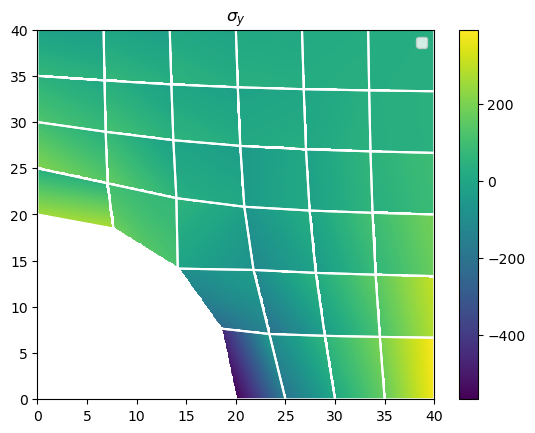

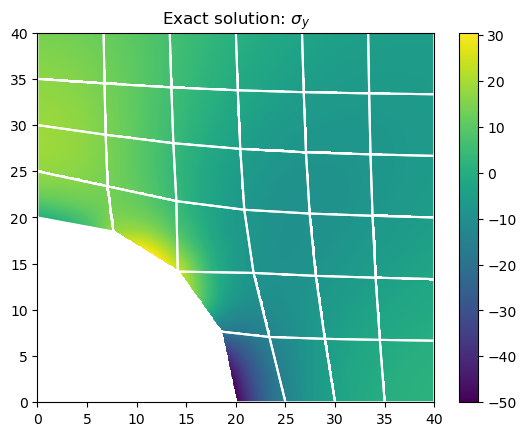

In [30]:
dir ='y'
type = 'stress'
if type == 'disp':
    type_str = 'U'
elif type == 'strain':
    type_str = '\\epsilon'
elif type == 'stress':
    type_str = '\\sigma'
dir_str = "{ %s }" % dir
iii = 1
refine =3 
elements_list = data_ori[iii]['elements_list']
a_b =data_ori[iii]['a_b'] 
draw(elements_list, dir, type)
draw_exact(elements_list,a_b, dir)

In [ ]:

draw(elements_list, dir, type)

150.0


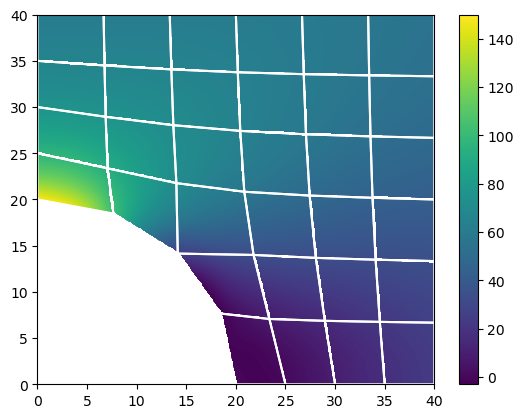

In [ ]:
stress = []
xys = []

global_min = min([np.min([exact_fn(xy[0], xy[1],data_ori[iii]['a_b'], dir) for xy in test_element.mapping(refine)]) for test_element in elements_list])
global_max = max([np.max([exact_fn(xy[0], xy[1],data_ori[iii]['a_b'], dir)for xy in test_element.mapping(refine)]) for test_element in elements_list])
print(global_max)
for i in range(len(elements_list)):
   test_element = elements_list[i]
   test_mapping = test_element.mapping(refine)
   test_output = [exact_fn(xy[0], xy[1],data_ori[iii]['a_b'], dir) for xy in test_mapping]
   test_x, test_y, test_z = grid_to_mat(test_mapping, test_output)
   plt.imshow(test_z, extent=(test_mapping[:, 0].min(),
                                    test_mapping[:, 0].max(),
                                    test_mapping[:, 1].min(),
                                    test_mapping[:, 1].max()),
                                    origin='lower', aspect='auto',
                                    interpolation='bilinear',
                                        vmin=global_min, vmax=global_max)
            # 绘制元素的边界
   vertices = test_element.vertices
   vertices = np.vstack([vertices, vertices[0]])  # 将第一个顶点再次添加到数组的末尾，以便封闭形状
   vertices_x, vertices_y = zip(*vertices)  # 解压顶点坐标
   plt.plot(vertices_x, vertices_y,  color='white')  # 使用黑色线绘制边界，并使用小圆点表示顶点s
plt.xlim(0, 40)
plt.ylim(0, 40)
# Display the color bar
plt.colorbar()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


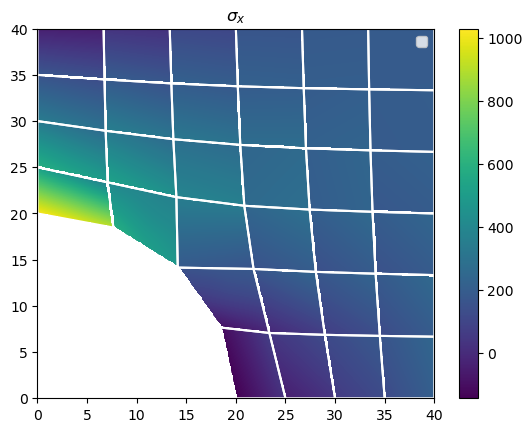

In [ ]:
print(data_ori[iii]['nodes_coord'])

[[ 2.00000000e+01 -1.18289774e-14]
 [ 2.22044605e-15  2.00000000e+01]
 [ 0.00000000e+00  4.00000000e+01]
 [ 4.00000000e+01  4.00000000e+01]
 [ 4.00000000e+01  0.00000000e+00]
 [ 1.41421356e+01  1.41421356e+01]
 [ 7.65366865e+00  1.84775907e+01]
 [ 1.84775907e+01  7.65366865e+00]
 [ 0.00000000e+00  3.00000000e+01]
 [ 0.00000000e+00  2.50000000e+01]
 [ 0.00000000e+00  3.50000000e+01]
 [ 2.66666667e+01  4.00000000e+01]
 [ 1.33333333e+01  4.00000000e+01]
 [ 6.66666667e+00  4.00000000e+01]
 [ 3.33333333e+01  4.00000000e+01]
 [ 2.00000000e+01  4.00000000e+01]
 [ 4.00000000e+01  1.33333333e+01]
 [ 4.00000000e+01  2.66666667e+01]
 [ 4.00000000e+01  2.00000000e+01]
 [ 4.00000000e+01  6.66666667e+00]
 [ 4.00000000e+01  3.33333333e+01]
 [ 3.00000000e+01  0.00000000e+00]
 [ 2.50000000e+01  0.00000000e+00]
 [ 3.50000000e+01  0.00000000e+00]
 [ 1.36958663e+01  2.80385594e+01]
 [ 2.80580281e+01  1.36805854e+01]
 [ 2.70664826e+01  2.70498563e+01]
 [ 3.35696350e+01  2.68294811e+01]
 [ 3.40868793e+01  1

In [ ]:
elem = data_ori[iii]['elements_list'][12]
print(elem)
elem.mapping(3)

[[ 0.         40.        ]
 [ 0.         35.        ]
 [ 6.75796943 34.50482932]
 [ 6.66666667 40.        ]]


array([[ 0.        , 40.        ],
       [ 3.33333333, 40.        ],
       [ 6.66666667, 40.        ],
       [ 0.        , 37.5       ],
       [ 3.35615902, 37.37620733],
       [ 6.71231805, 37.25241466],
       [ 0.        , 35.        ],
       [ 3.37898472, 34.75241466],
       [ 6.75796943, 34.50482932]])

ValueError: z array must have same length as triangulation x and y arrays

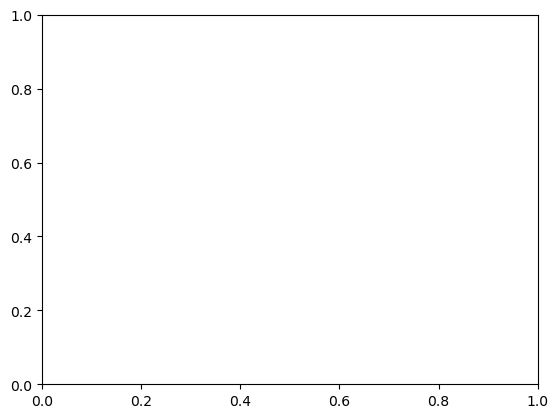

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 从 nodes_coord 获取 x 和 y 坐标
x = [coord[0] for coord in data_ori[iii]['nodes_coord']]
y = [coord[1] for coord in data_ori[iii]['nodes_coord']]

# 使用 tricontourf 绘制填充轮廓图
plt.tricontourf(x, y, stress, levels=100, cmap='hot')
plt.colorbar()
plt.title("Stress Heatmap")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")  # 使坐标轴等比例
plt.show()
